# Activation Functions

We'll use graphs for this notebook, as well as numpy, so let's get that rolling:

In [1]:
# This makes our charts appear in the notebook, instead of a useless popup window.
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In this notebook, we will discuss various activation functions.  All of these will be useful at some time or another, and all of them will work with the code we've already written.  Thus we might imagine the code for each function will look like this:

In [2]:
def act(z):
    return z+1

The inputs to our functions will always be numpy arrays, so the code should automatically vectorize. In practice this is not difficult; numpy has designed its notation so that this usually works automatically.

Also, for the purposes of training our neural networks, we will need the derivatives of each of these functions as well.  Thus, our code might look more like this:

In [3]:
def act(z, diff=False):
    if diff:
        return 1
    else:
        return z+1

The conditional seems inefficient, but it's only doing it once for the whole matrix, so it doesn't really cost much, and it makes our usage code a lot more efficient.

We really do spend a lot of time computing these functions, which often involve expensive functions like `exp` or `tanh`.  Often the derivative can be computed without use of these expensive functions, if we already have the output of the function itself; that is, we could compute $f'(z)$ efficiently from $f(z)$.

Conveniently, we always need $f'(z)$ after we have already computed $f(z)$, so this is easy to accomplish.  Our final schema looks like this:

In [4]:
def act(z, y=None, diff=False):
    if diff:
        return 1
    else:
        return z+1

We'll have some check so that if $y$ is already computed, we can take advantage of it.

## Sigmoid

The most common function used in this context is the sigmoid function, although recent research suggests it may not be the best option.  It's easy to work with, though.  The formula is simply this: $$f(z)=\dfrac{1}{1+e^{-z}}$$

The derivative is $$f'(z)=-e^{-z}\cdot (1+e^{-z})^{-2}$$

This derivative involves two exponentials, although they're the same exponential and we could save the result.  It can be rearranged in various ways, but it'll never not involve an exponential.  However, this function has a cute shortcut: $$f'(z)=f(z)\cdot (1-f(z))$$

Clearly this is cheap to compute.  Our code looks like this:

In [5]:
def act_sigmoid(z, y=None, diff=False):
    if diff:
        if y is None:
            ex = np.exp(-z)
            return -ex / ((1+ex)**2)
        else:
            return y*(1-y)
    else:
        return 1 / (1 + np.exp(-z))

The graph looks like this:

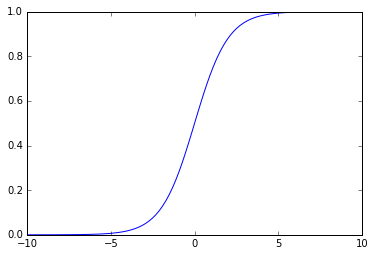

In [6]:
x = np.linspace(-10, 10, 100)
y = act_sigmoid(x)

plt.plot(x, y)
plt.show()

The sigmoid function gives $0.5$ when given zero, and is increasing -- so larger arguments get larger, to a maximum of one, and smaller (more negative) arguments get smaller, to a minimum of zero.  The function is everywhere smooth and well-behaved.

It is important to note that, while this function is popular in the basic literature, new research suggests this function is **unsuitable for deep neural networks** (see for example Glorot and Bengio, 2010). The problem is that for "random" input, it outputs 0.5.  When you feed 0.5 into the sigmoid, you get a bit higher number, and after a few levels of composition, it's very close to 1 with a very small derivative.  This means it has difficulty changing its behavior and has difficulty doing anything useful.

This problem is called "saturation."  Giving enough training time, it will eventually overcome it, but training time is expensive.  Indeed in experiments with a mere 5-level network using sigmoid activations, the network "never overcame the saturation" (again, Glorot and Bengio 2010).  In any case, other activation functions tend to be better, which we discuss now.

## Hyperbolic Tangent

Another very common function used in this context is the hyperbolic tangent function, which is also quite well-behaved.  The formula is simply: $$f(z)=\tanh(z)$$

Note that there are many rephrasings of this definition involving exponentials, but numpy has a built-in implementation of $\tanh$ which is efficient, so there's no need to re-implement anything.

Happily, the derivative is very convenient to compute: $$f'(z)=\textrm{sech}^2(z)=1-\tanh^2(z)=1-(f(z))^2$$

In [7]:
def act_tanh(z, y=None, diff=False):
    if diff:
        if y is None:
            y = np.tanh(z)
        return 1-y*y
    else:
        return np.tanh(z)

The graph looks like this:

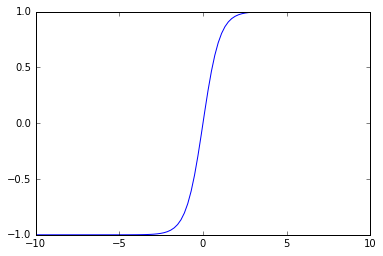

In [8]:
x = np.linspace(-10, 10, 100)
y = act_tanh(x)

plt.plot(x, y)
plt.show()

It's a little steeper than the sigmoid function, but the shape is approximately the same.  Also, when you plug in zero, you get zero, and the output ranges from $-1$ to $1$, which is often convenient.

## Identity (No Activation)

For input or hidden nodes, it's important to give a nonlinear activation function, so that the layer isn't a waste of time.  However, for regression networks (as opposed to classification), the output neurons should be unbounded, and it seems to work well to simply not to activate them at all.  Thus:

$$f(z)=z$$
$$f'(z)=1$$

The code is quite easy to code up, of course: 

In [9]:
def act_identity(z, y=None, diff=False):
    if diff:
        return 1
    else:
        return z

## LeRU (Leaky Rectifier Unit)

A final activation function, which in recent years has been shown to be extremely useful for deep networks, is called a LeRU -- a leaky rectifier unit.

A rectifier unit is a piecewise function: if the input $z$ is positive, it returns $z$. If $z$ is nonpositive, it returns 0.

A *leaky* rectifier unit return $az$ if $z<0$, where $a$ is a small constant.  If $a=0$ this is just the usual rectifier unit; if $a$ is slightly positive, this lets the output reflect the input a bit more, going negative.  Both choices are common.

Coding it is slightly more involved, because we don't want to add another parameter to our activation function. Instead we'll make a LeRU factory.

In [10]:
def act_LeRU_maker(leakage=0):
    def f(z, y=None, diff=False):
        if diff:
            return np.where(z>0, 1, leakage)
        else:
            return np.where(z>0, z, leakage*z)
    
    return f

act_LeRU = act_LeRU_maker(leakage=0)

For simplicity, and because this is the most common usage, we've included `act_LeRU` as the default LeRU activation function.  Here is its graph, exactly as described:

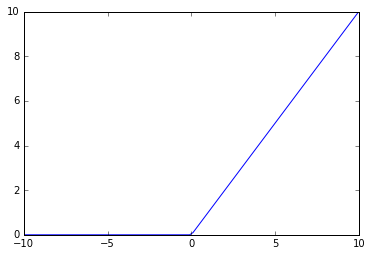

In [11]:
x = np.linspace(-10, 10, 100)
y = act_LeRU(x)

plt.plot(x, y)
plt.show()

It's worth pointing out that technically, the LeRU functions are non-differentiable at zero.  It's possible to consider this problematic, and consider the "softplus" function, $y=\ln(1+e^x)$.  This function is smooth everywhere, which is convenient, and the effect is a somewhat smoothed out version of the original function.  See the graphs together:

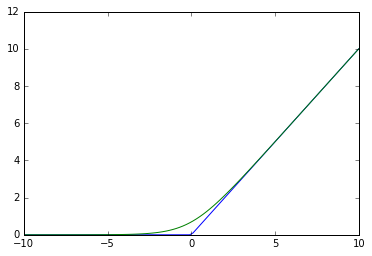

In [12]:
x = np.linspace(-10, 10, 100)
y = act_LeRU(x)
z = np.log(1+np.exp(x))

plt.plot(x, y)
plt.plot(x, z)
plt.show()

It's a pretty good approximation, but it's expensive to compute. Additionally, its derivative is $f'(x)=\frac{1}{1+e^{-x}}$ (coincidentally, this is sigmoid function, although this is not useful for us), and we don't have a shortcut for its derivative, so it hurts twice.

More importantly, it's not clear what we gain.  There are very few problems that actually arise from this non-differentiability in practice, so we'll just use the default LeRU.  However, just for sake of completeness, we will include an implementation of softplus:

In [13]:
def act_softplus(z, y=None, diff=False):
    if diff:
        return 1 / (1 + np.exp(-z))
    else:
        return np.log(1+np.exp(z))